# Negative L1 norm prior experiment

This code attempts to learn the 2D prior
$J(x) = -||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i) = -t/2 - |x|$

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/NegL1_prior_2D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Negative L1 Norm J(x) = -||x||_1
    # S(x, t) = -t/2 - |x| (per dimension)
    # For n dimensions: S(x, t) = - (n*t)/2 - ||x||_1
    
    dim = y.shape[1]
    l1_norm = np.sum(np.abs(y), axis=1)
    return -(t) / 2.0 - l1_norm


def prior_true(y):
    # J(x) = -||x||_1
    return -np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Convex functions(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Convex functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}")
        plt.xlabel('$x_1$')
        plt.ylabel('Prior functions ($0,x_2$,0)')
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 2

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 20000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 102.60687255859375
iteration 0 loss 1030.405517578125


iteration 5000 loss 0.0045669241808354855


iteration 10000 loss 0.0016723449807614088


iteration 15000 loss 0.001120551023632288


iteration 20000 loss 0.0008275710861198604


iteration 25000 loss 0.0006858909619040787


iteration 30000 loss 0.0005624079494737089


iteration 35000 loss 0.0005046039586886764


iteration 40000 loss 0.0004516011103987694


iteration 45000 loss 0.0005053869099356234


iteration 50000 loss 0.0003989223041571677


iteration 55000 loss 0.0004210665647406131


iteration 60000 loss 0.0003707546566147357


iteration 65000 loss 0.0003424428286962211


iteration 70000 loss 0.07781339436769485


iteration 75000 loss 0.0003115122381132096


iteration 80000 loss 0.0002989338245242834


iteration 85000 loss 0.0002870580938179046


iteration 90000 loss 0.0002814068866427988


iteration 95000 loss 0.0002838721266016364


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.0002668568631634116


iteration 105000 loss 0.00025054209982044995


iteration 110000 loss 0.00023464116384275258


iteration 115000 loss 0.00022296850511338562


iteration 120000 loss 0.000213102568523027


iteration 125000 loss 0.00020489702001214027


iteration 130000 loss 0.0001974782207980752


iteration 135000 loss 0.00019052460265811533


iteration 140000 loss 0.0001841751072788611


iteration 145000 loss 0.0001783316838555038


iteration 150000 loss 0.00017290176765527576


iteration 155000 loss 0.00016769034846220165


iteration 160000 loss 0.0001630627375561744


iteration 165000 loss 0.00015859644918236881


iteration 170000 loss 0.00015445114695467055


iteration 175000 loss 0.00015032864757813513


iteration 180000 loss 0.00014639826258644462


iteration 185000 loss 0.00014283476048149168


iteration 190000 loss 0.00013966964615974575


iteration 195000 loss 0.0001362290495308116


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.00039392217877320945


iteration 205000 loss 0.0001325057091889903


iteration 210000 loss 0.0001296336849918589


iteration 215000 loss 0.00012689176946878433


iteration 220000 loss 0.00012422278814483434


iteration 225000 loss 0.00012167999375378713


iteration 230000 loss 0.00011932101187994704


iteration 235000 loss 0.00011695535795297474


iteration 240000 loss 0.00011484422429930419


iteration 245000 loss 0.00011281182378297672


iteration 250000 loss 0.00011079877003794536


iteration 255000 loss 0.0001088336794055067


iteration 260000 loss 0.00010691349598346278


iteration 265000 loss 0.00010517598275328055


iteration 270000 loss 0.0001035089444485493


iteration 275000 loss 0.00010192589252255857


iteration 280000 loss 0.00010027561074821278


iteration 285000 loss 9.883214079309255e-05


iteration 290000 loss 0.00018148824165109545


iteration 295000 loss 9.593130380380899e-05


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 9.454705286771059e-05


iteration 305000 loss 9.409532503923401e-05


iteration 310000 loss 9.263694664696231e-05


iteration 315000 loss 9.126660734182224e-05


iteration 320000 loss 8.992492803372443e-05


iteration 325000 loss 8.861537935445085e-05


iteration 330000 loss 8.734879520488903e-05


iteration 335000 loss 8.611445082351565e-05


iteration 340000 loss 8.491849439451471e-05


iteration 345000 loss 8.375642210012302e-05


iteration 350000 loss 8.263007475761697e-05


iteration 355000 loss 8.153148519340903e-05


iteration 360000 loss 8.044502465054393e-05


iteration 365000 loss 7.940459181554615e-05


iteration 370000 loss 7.838742749299854e-05


iteration 375000 loss 7.739957072772086e-05


iteration 380000 loss 7.647808524779975e-05


iteration 385000 loss 7.553513569291681e-05


iteration 390000 loss 7.477281906176358e-05


iteration 395000 loss 7.37942464184016e-05


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 7.290038047358394e-05


iteration 405000 loss 7.262228609761223e-05


iteration 410000 loss 7.220421684905887e-05


iteration 415000 loss 7.17992297722958e-05


iteration 420000 loss 7.140333036659285e-05


iteration 425000 loss 7.101405935827643e-05


iteration 430000 loss 7.063183875288814e-05


iteration 435000 loss 7.025519880698994e-05


iteration 440000 loss 6.988234963500872e-05


iteration 445000 loss 6.951078830752522e-05


iteration 450000 loss 6.914195546414703e-05


iteration 455000 loss 6.877604755572975e-05


iteration 460000 loss 6.841235153842717e-05


iteration 465000 loss 6.805187877034768e-05


iteration 470000 loss 6.769516039639711e-05


iteration 475000 loss 6.73425747663714e-05


iteration 480000 loss 6.699377991026267e-05


iteration 485000 loss 6.664533430011943e-05


iteration 490000 loss 6.629955896642059e-05


iteration 495000 loss 6.59575525787659e-05


L2 loss -- Plot

loss 62.54175567626953


loss 15.714723587036133


loss -13.640695571899414


loss -33.11726760864258


loss -44.920387268066406


loss -51.851741790771484


loss -55.55718994140625


loss -57.32411575317383


loss -58.057456970214844


loss -58.31026840209961


loss -58.377750396728516


loss -58.39046096801758


loss -58.391963958740234


loss -58.392066955566406


loss -58.39206314086914


loss -58.39207077026367


loss -58.392066955566406


loss -58.392066955566406


loss -58.39207458496094


loss -58.39207077026367


loss -58.39207458496094


loss -58.39207077026367


loss -58.392066955566406


loss -58.392066955566406


loss -58.392066955566406


loss -58.39207458496094


loss -58.39207077026367


loss -58.392059326171875


loss -58.39206314086914


loss -58.39207458496094


loss -58.39207458496094


loss -58.39207077026367


loss -58.392066955566406


loss -58.39207077026367


loss -58.392066955566406


loss -58.39207458496094


loss -58.39206314086914


loss -58.392066955566406


loss -58.39207077026367


loss -58.39207077026367


final mse:  3.162263340072968e-08
max, min: 3.0027716 -3.0005405
loss 62.54175567626953


loss 14.862003326416016


loss -13.92718505859375


loss -33.675960540771484


loss -45.50349426269531


loss -52.487098693847656


loss -56.30304718017578


loss -58.12145233154297


loss -58.86930465698242


loss -59.128089904785156


loss -59.19853973388672


loss -59.212215423583984


loss -59.213905334472656


loss -59.214019775390625


loss -59.214019775390625


loss -59.214019775390625


loss -59.214027404785156


loss -59.21402359008789


loss -59.214019775390625


loss -59.214019775390625


loss -59.214027404785156


loss -59.214027404785156


loss -59.21402359008789


loss -59.214027404785156


loss -59.214027404785156


loss -59.21403121948242


loss -59.214027404785156


loss -59.214027404785156


loss -59.214019775390625


loss -59.214027404785156


loss -59.214019775390625


loss -59.214027404785156


loss -59.214027404785156


loss -59.21402359008789


loss -59.214019775390625


loss -59.21402359008789


loss -59.214019775390625


loss -59.214019775390625


loss -59.21402359008789


loss -59.214027404785156


final mse:  4.066360759225063e-08
max, min: 3.0043285 -3.008476


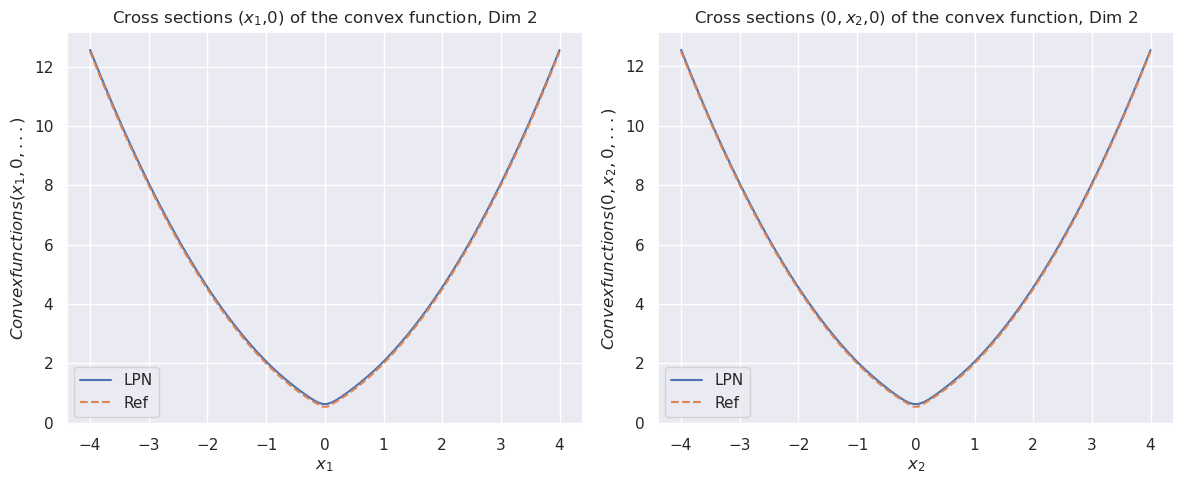

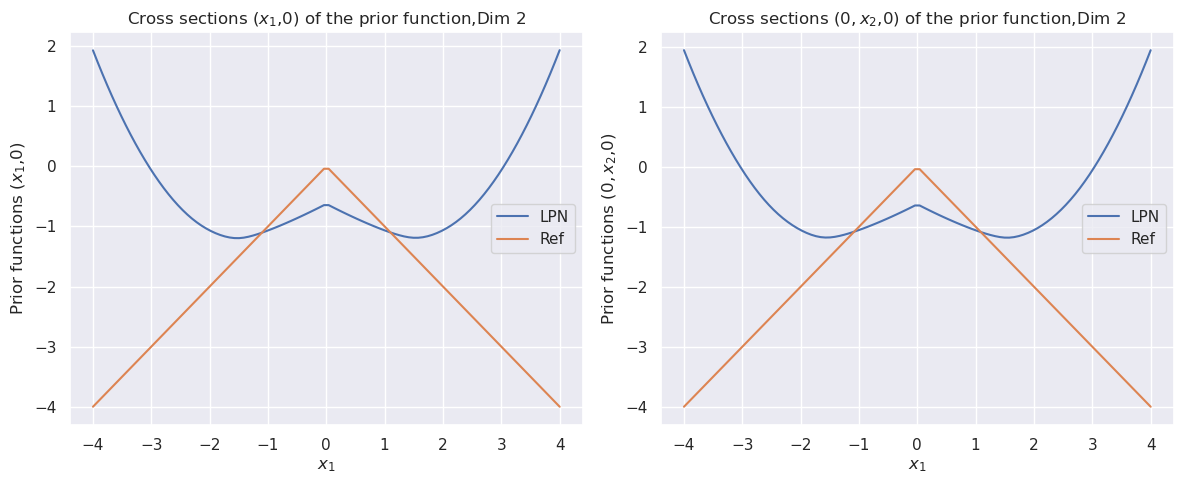

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 36.85246276855469
iteration 0 loss 2169.6240234375


iteration 5000 loss 0.0026957790832966566


iteration 10000 loss 0.0007601364050060511


iteration 15000 loss 0.00048085354501381516


iteration 20000 loss 0.0004577895160764456


iteration 25000 loss 0.0002601704909466207


iteration 30000 loss 0.0003574269649107009


iteration 35000 loss 0.00017758624744601548


iteration 40000 loss 0.00017012587341014296


iteration 45000 loss 0.0001319457805948332


iteration 50000 loss 0.00011017915676347911


iteration 55000 loss 0.00010505494719836861


iteration 60000 loss 0.00010215825750492513


iteration 65000 loss 8.463396079605445e-05


iteration 70000 loss 8.346162940142676e-05


iteration 75000 loss 7.488281698897481e-05


iteration 80000 loss 6.923592445673421e-05


iteration 85000 loss 6.458687857957557e-05


iteration 90000 loss 6.588478572666645e-05


iteration 95000 loss 5.434167178464122e-05


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 4.690784771810286e-05


iteration 105000 loss 3.879745418089442e-05


iteration 110000 loss 3.188322443747893e-05


iteration 115000 loss 2.7451773348730057e-05


iteration 120000 loss 2.9896897103753872e-05


iteration 125000 loss 2.240895264549181e-05


iteration 130000 loss 3.630663195508532e-05


iteration 135000 loss 1.9347449779161252e-05


iteration 140000 loss 1.8214173906017095e-05


iteration 145000 loss 1.7232063328265212e-05


iteration 150000 loss 1.6329526260960847e-05


iteration 155000 loss 1.5581401385134086e-05


iteration 160000 loss 1.49001061799936e-05


iteration 165000 loss 1.4311956874735188e-05


iteration 170000 loss 1.3750277503277175e-05


iteration 175000 loss 1.3255283192847855e-05


iteration 180000 loss 1.2811994565709028e-05


iteration 185000 loss 1.2377941857266705e-05


iteration 190000 loss 1.198583504447015e-05


iteration 195000 loss 1.164876448456198e-05


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 1.1300397090963088e-05


iteration 205000 loss 1.1105950761702843e-05


iteration 210000 loss 1.0799045412568375e-05


iteration 215000 loss 1.052394691214431e-05


iteration 220000 loss 1.0271314749843441e-05


iteration 225000 loss 1.0025123629020527e-05


iteration 230000 loss 9.794380275707226e-06


iteration 235000 loss 9.582411621522624e-06


iteration 240000 loss 9.382154530612752e-06


iteration 245000 loss 9.184428563457914e-06


iteration 250000 loss 8.99956557987025e-06


iteration 255000 loss 8.828952559269965e-06


iteration 260000 loss 8.660565072204918e-06


iteration 265000 loss 8.495930160279386e-06


iteration 270000 loss 8.349790732609108e-06


iteration 275000 loss 8.208387043850962e-06


iteration 280000 loss 8.06983280199347e-06


iteration 285000 loss 7.93923572928179e-06


iteration 290000 loss 7.819046004442498e-06


iteration 295000 loss 7.698809895373415e-06


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 7.580491910630371e-06


iteration 305000 loss 7.511661806347547e-06


iteration 310000 loss 7.400757567666005e-06


iteration 315000 loss 7.294172064575832e-06


iteration 320000 loss 7.192580142145744e-06


iteration 325000 loss 7.0955675255390815e-06


iteration 330000 loss 7.004120107012568e-06


iteration 335000 loss 6.9130805968598e-06


iteration 340000 loss 6.829796348029049e-06


iteration 345000 loss 6.7449018388288096e-06


iteration 350000 loss 6.670020411547739e-06


iteration 355000 loss 6.597307219635695e-06


iteration 360000 loss 6.5215772337978706e-06


iteration 365000 loss 6.455170932895271e-06


iteration 370000 loss 6.386891072907019e-06


iteration 375000 loss 6.324431069515413e-06


iteration 380000 loss 6.264566309255315e-06


iteration 385000 loss 6.204874807735905e-06


iteration 390000 loss 6.146641226223437e-06


iteration 395000 loss 6.092747298680479e-06


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 6.039737399987644e-06


iteration 405000 loss 6.016449333401397e-06


iteration 410000 loss 5.959312147751916e-06


iteration 415000 loss 5.903511919314042e-06


iteration 420000 loss 5.849006811331492e-06


iteration 425000 loss 5.7973516049969476e-06


iteration 430000 loss 5.746092483605025e-06


iteration 435000 loss 5.696064818039304e-06


iteration 440000 loss 5.648801561619621e-06


iteration 445000 loss 5.603156296274392e-06


iteration 450000 loss 5.557695658353623e-06


iteration 455000 loss 5.514513759408146e-06


iteration 460000 loss 5.472561042552115e-06


iteration 465000 loss 5.432373654912226e-06


iteration 470000 loss 5.393101673689671e-06


iteration 475000 loss 5.354257154976949e-06


iteration 480000 loss 5.316659553500358e-06


iteration 485000 loss 5.279541710478952e-06


iteration 490000 loss 5.243089617579244e-06


iteration 495000 loss 5.207282356423093e-06


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


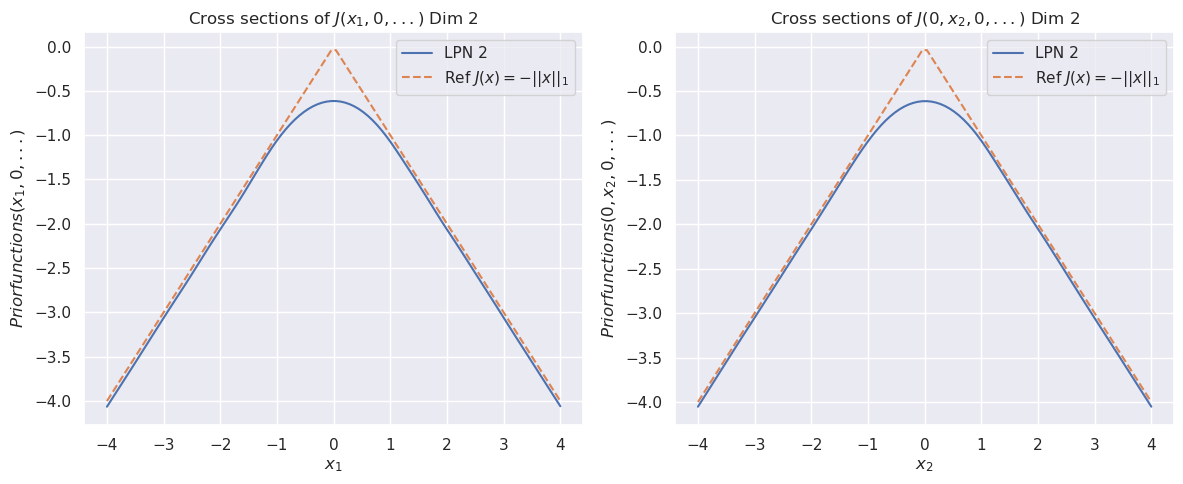

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)